In [1]:
from sklearn.model_selection import train_test_split
from __future__ import print_function
import os, sys, collections
import numpy as np
from numpy import linalg as LA
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers.core import Dense, Flatten
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM, Merge
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Sequential, Model
from keras.constraints import unitnorm
import keras.backend as K
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from random import shuffle, sample
#from nlp_utility import *

Using TensorFlow backend.


## Functions to import input files

In [2]:
def read_sentences(handle):
 for l in handle:
   if l.strip():
     yield l.strip()

def process(sentence):
  s = sentence.split(',')
  qid = int(s[0].strip(","))
  answer = splitWords(removePunctations(s[1].strip(",")))
  answer_parsed = " ".join(str(word) for word in answer)
  return qid,answer_parsed


def readfile(fn, y_label):
  sen = []
  for sentence in read_sentences(open(fn)):
    try:    
      a,b = process(sentence)
      sen.append([a, y_label, b])
    except:
      pass
  return sen

def splitWords(sentence):
  return sentence.lower().split(' ')

def removePunctations(text):
  return ''.join(t for t in text if t.isalnum() or t == ' ')

In [3]:
best_file = "/Users/yan/Code/lawyer_answer_spam_classifier/best.csv"
worst_file = "/Users/yan/Code/lawyer_answer_spam_classifier/worst.csv"
best_sen = readfile(best_file, 1)
worst_sen = readfile(worst_file, 0)
sen = best_sen + worst_sen[:5000]

In [4]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200
np.random.seed(1337)

In [5]:
texts = [i[2] for i in sen]
tokenizer = Tokenizer(VOCAB_SIZE, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=" ", char_level=False)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
index_word = dict(zip(word_index.values(), word_index.keys()))
print('Found %s unique tokens.' % len(word_index))
print(len(sequences[2]),len(sequences))

Found 10942 unique tokens.
14 10000


In [25]:
for i in xrange(len(sequences)):
    sen[i].append(sequences[i])

In [27]:
y_label = [i[1] for i in sen]
X_train, X_test, label_train, label_test = train_test_split(sen, y_label, test_size=0.1, random_state=42)

In [28]:
X_train_data = [ i[3]  for i in X_train]
X_test_data = [ i[3]  for i in X_test]

In [29]:
X_train_data_arr = pad_sequences(X_train_data, maxlen=MAX_SEQUENCE_LENGTH, value=0)
X_test_data_arr = pad_sequences(X_test_data, maxlen=MAX_SEQUENCE_LENGTH, value=0)

In [30]:
label_train = np.asarray(label_train)
label_test = np.asarray(label_test)

In [33]:
X_train[:2]

[[1818533, 1, 'legally speaking', [806, 518]],
 [1805245,
  1,
  'more than likely your childs other parent is permitted to take the child out of state',
  [62, 138, 170, 6, 1045, 79, 472, 5, 1793, 3, 117, 1, 120, 70, 7, 88]]]

## First approach with random initialization of embedding word vectors

In [34]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer_word = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,embeddings_constraint=unitnorm(axis=1))
embedded_sequences = embedding_layer_word(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Flatten()(x)
x = Dense(640, activation='relu')(x)
Dropout (0.25)
preds = Dense(1, activation='sigmoid')(x)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.fit(X_train_data_arr, label_train, validation_data=(X_test_data_arr, label_test),epochs=3, batch_size=128)

Train on 9000 samples, validate on 1000 samples
Epoch 1/3
9000/9000 [==============================] - 15s - loss: 0.6418 - acc: 0.6141 - val_loss: 0.5707 - val_acc: 0.6750

## Second approach: import Glove embedding vectors as initialization

In [20]:
def get_glove():
    glove_file = "/Users/yan/Code/keras/glove.6B.100d.txt"
    with open(glove_file) as glove:
      lines = glove.readlines()
    glove = {}
    for line in lines:
        line_split = line.split(' ')
        word = line_split[0]
        embedding = np.array([float(val) for val in line_split[1:]])
        glove[word] = embedding
    return glove

In [21]:
glove = get_glove()

In [22]:
embedding_matrix = np.zeros((len(word_index), 100))
for word, i in word_index.items():
    if word in glove:
        embedding_matrix[i] = glove.get(word)

In [23]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer_word = Embedding(input_dim=len(word_index), output_dim=100, input_length=MAX_SEQUENCE_LENGTH,weights=[embedding_matrix],embeddings_constraint=unitnorm(axis=1))
embedded_sequences = embedding_layer_word(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
Dropout (0.25)
preds = Dense(1, activation='sigmoid')(x)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.fit(X_train_data_arr, label_train, validation_data=(X_test_data_arr, label_test),epochs=3, batch_size=128)

Train on 9000 samples, validate on 1000 samples
Epoch 1/3
9000/9000 [==============================] - 11s - loss: 0.6436 - acc: 0.6082 - val_loss: 0.6006 - val_acc: 0.6710

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 100)          1094200   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 196, 128)          64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4992)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                159776    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total para

## Draw confusion matrix

In [35]:
preds = model.predict(X_test_data_arr)
#cm = confusion_matrix(label_test, preds)

In [36]:
preds_class = [ 1 if i > 0.5 else 0 for i in preds]

In [46]:
X_test_output =[ [a[1], a[2], b[0], c] for a, b, c in zip(X_test, preds, preds_class)]

In [49]:
X_test_output[:3]

[[0, 'this is a duplicate question handled earlier today', 0.26565561, 0],
 [1,
  'it depends on how the restraining order is worded defendants often use third parties to do their dirty work when a retraining order has been issued against them that is why some',
  0.92706317,
  1],
 [1, 'first', 0.50571018, 1]]

In [54]:
import csv
out = csv.writer(open("lawyer_spam_testset_output.csv","w"), delimiter='\n')
out.writerow(X_test_output)

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(label_test, np.asarray(preds_class))

In [28]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [29]:
label_test[:3]

array([0, 1, 1])

In [30]:
plot_confusion_matrix(cm, {'worst':0, 'best':1})

Confusion matrix, without normalization
[[279 229]
 [ 68 424]]


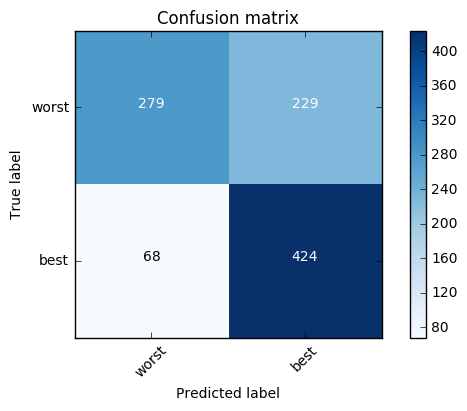

In [31]:
plt.show()